## Trabalho 2 - Aprendizado Não Supervisionado

### Nelson Dell Osbel Junior e Cristiano Moreira Martins

### Comecei importando as bibliotecas necesarias

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
import seaborn as sn
from sklearn.manifold import TSNE

warnings.filterwarnings('ignore')

### Li a base de dados e mostrei alguns informações relevantes

In [2]:
df = pd.read_csv('D:/Disco/Data/datasus/SINASC/sinasc_nascimentos/sinasc_nascimentos.csv', delimiter=';')

df.head()

,data_extracao,data_nascimento,escolaridade_mae,raca_mae,estado_civil_mae,nascimento_mae,cbo_mae,ocupacao,nro_consultas_prenatal,cesaria_antes_parto,...,local_nascimento,parto,trabalho_parto,apresentacao_crianca,classe_robson,peso,possui_anomalia,cid_anomalia,sexo,raca
0,2023-07-01 01:35:37.359,10/2021,DE 8 A 11 ANOS,BRANCA,SOLTEIRO,07/1990,999992.0,DONA DE CASA,7 OU MAIS CONS,NaN,...,HOSPITAL,VAGINAL,INDUZIDO,CEFÁLICA,NaN,3555,NÃO,NaN,FEMININO,NaN
1,2023-07-01 01:35:37.359,11/2021,DE 8 A 11 ANOS,BRANCA,SOLTEIRO,07/1997,999992.0,DONA DE CASA,DE 4 A 6 CONS,NÃO,...,HOSPITAL,CESAREO,NÃO INDUZIDO,CEFÁLICA,NaN,3250,NÃO,NaN,MASCULINO,NaN
2,2023-07-01 01:35:37.359,11/2021,DE 8 A 11 ANOS,BRANCA,UNIAO CONSENSUAL,10/1999,999992.0,DONA DE CASA,7 OU MAIS CONS,NaN,...,HOSPITAL,VAGINAL,NÃO INDUZIDO,CEFÁLICA,NaN,3755,NÃO,NaN,FEMININO,NaN
3,2023-07-01 01:35:37.359,11/2021,DE 8 A 11 ANOS,PARDA,SOLTEIRO,06/2001,999992.0,DONA DE CASA,DE 4 A 6 CONS,NaN,...,HOSPITAL,VAGINAL,NÃO INDUZIDO,CEFÁLICA,NaN,3335,NÃO,NaN,MASCULINO,NaN
4,2023-07-01 01:35:37.359,11/2021,DE 4 A 7 ANOS,BRANCA,SOLTEIRO,12/2002,999992.0,DONA DE CASA,DE 4 A 6 CONS,NaN,...,HOSPITAL,VAGINAL,NÃO INDUZIDO,CEFÁLICA,NaN,3475,NÃO,NaN,MASCULINO,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197801 entries, 0 to 197800
Data columns (total 22 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   data_extracao           197801 non-null  object 
 1   data_nascimento         197801 non-null  object 
 2   escolaridade_mae        197723 non-null  object 
 3   raca_mae                194648 non-null  object 
 4   estado_civil_mae        197737 non-null  object 
 5   nascimento_mae          194645 non-null  object 
 6   cbo_mae                 197600 non-null  float64
 7   ocupacao                197600 non-null  object 
 8   nro_consultas_prenatal  197801 non-null  object 
 9   cesaria_antes_parto     98299 non-null   object 
 10  duracao_gestacao        197699 non-null  object 
 11  gravidez                197777 non-null  object 
 12  local_nascimento        197801 non-null  object 
 13  parto                   197786 non-null  object 
 14  trabalho_parto      

### Trasnformei as colunas de data em formato de data

In [4]:
df['nascimento_mae'] = pd.to_datetime(df['nascimento_mae'])
df['data_nascimento'] = pd.to_datetime(df['data_nascimento'])
df['data_extracao'] = pd.to_datetime(df['data_extracao'])

### Criei uma coluna de idade da mãe para substituir a coluna de nascimento da mãe

In [5]:
df.dropna(subset='nascimento_mae', inplace=True)
df['idade_mae'] = ((df['data_nascimento'] - df['nascimento_mae']) / 365.25)
df['idade_mae'] = df['idade_mae'].apply(lambda x: round(x.days))

#### Plot de alguns graficos para visualizar os dados

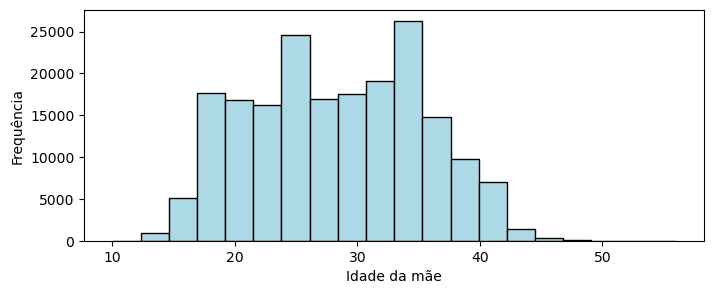

In [6]:
plt.figure(figsize=(8, 3))
plt.hist(df['idade_mae'], bins=20, edgecolor='black', color='lightblue')
plt.xlabel('Idade da mãe')
plt.ylabel('Frequência')
plt.show()

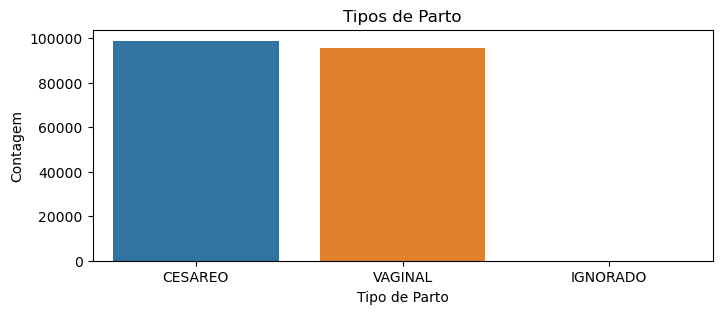

In [7]:
parto_counts = df['parto'].value_counts()

plt.figure(figsize=(8, 3))
sn.barplot(x=parto_counts.index, y=parto_counts.values)
plt.title('Tipos de Parto')
plt.xlabel('Tipo de Parto')
plt.ylabel('Contagem')
plt.show()

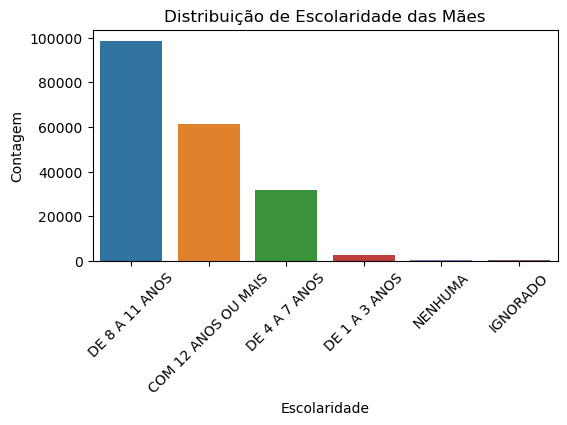

In [8]:
escolaridade_counts = df['escolaridade_mae'].value_counts()

plt.figure(figsize=(6, 3))
sn.barplot(x=escolaridade_counts.index, y=escolaridade_counts.values)
plt.xticks(rotation=45)
plt.title('Distribuição de Escolaridade das Mães')
plt.xlabel('Escolaridade')
plt.ylabel('Contagem')
plt.show()

### Transformei as variaveis categóricas em númericas para fazer as análises

In [9]:
cols = [
    'escolaridade_mae', 'raca_mae', 'estado_civil_mae', 'nascimento_mae', 
    'ocupacao', 'nro_consultas_prenatal', 'cesaria_antes_parto', 
    'duracao_gestacao', 'gravidez', 'local_nascimento', 'parto', 
    'trabalho_parto', 'apresentacao_crianca', 'possui_anomalia', 'sexo', 'raca'
]

In [10]:
colsv = []
for col in cols:
    df[col].fillna('IGNORADO', inplace=True)
    df[col] = df[col].astype('category')
    le = LabelEncoder()
    df[col + '_v'] = le.fit_transform(df[col])
    colsv.append(col + '_v')

df['cbo_mae'].fillna('IGNORADO', inplace=True)

### Plotei um gráfico com 2 variáveis mais relevantes

7 OU MAIS CONS    145606
DE 4 A 6 CONS      33845
DE 1 A 3 CONS      11443
NENHUMA             3607
IGNORADO             144
Name: nro_consultas_prenatal, dtype: int64


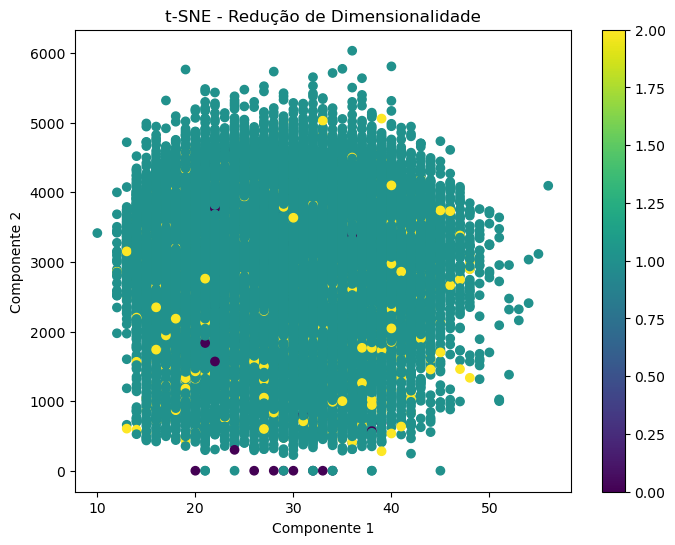

In [11]:
# Plotando o gráfico antes do t-SNE para comparação
print(df['nro_consultas_prenatal'].value_counts())
plt.figure(figsize=(8, 6))
plt.scatter(df.idade_mae, df.peso, c=df.possui_anomalia_v, cmap='viridis')
plt.title("t-SNE - Redução de Dimensionalidade")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.colorbar()
plt.show()

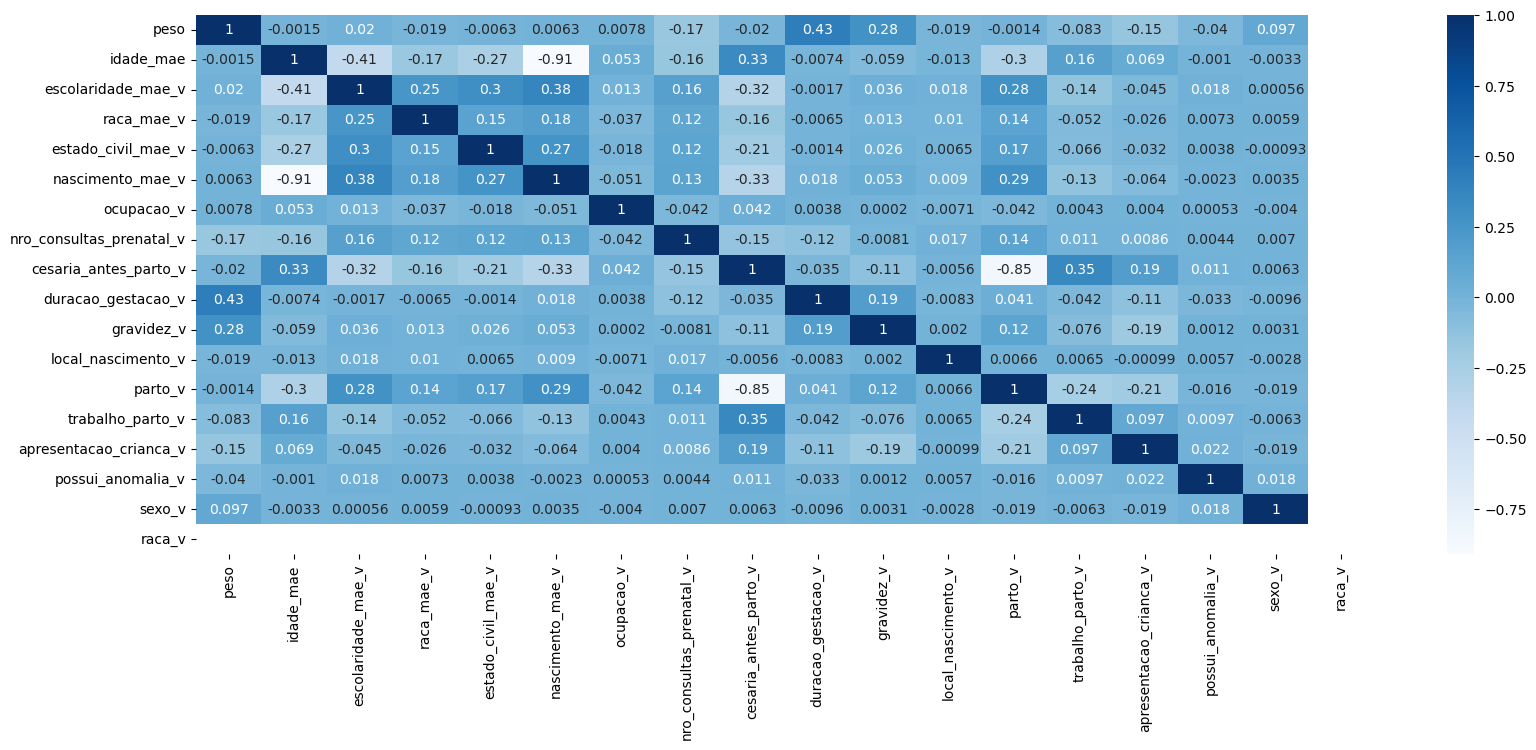

In [12]:
# tenta encontrar variaveis relacionadas
corr_matrix = df.select_dtypes(include=[np.number]).corr()

plt.figure(figsize=(19, 7))
sn.heatmap(corr_matrix, annot=True, cmap='Blues')
plt.show()

- Na matriz de correlação é possível verificar algumas variáveis que podem ter relação, o que pode ajudar na clusterização
    - peso: duracao_gestacao, gravidez
    - escolaridade_mae: raca_mae, estado_civil_mae, nro_consultas_prenatal, parto
    - estado_civil_mae: nro_consultas_prenatal, cesaria_antes_parto, parto
    - nro_consultas_prenatal: cesaria_antes_parto, duracao_gestacao, parto
    - duracao_gestacao: gravidez, apresentacao_crianca

### Separa as colunas com algum nível de correlação para utilizalas. Possivelmente essas colunas podem auxiliar no agrupamento de instancias

In [13]:

threshold = 0.15  # Define o limiar de alta correlação
high_corr_pairs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            col_pair = (corr_matrix.columns[i], corr_matrix.columns[j])
            high_corr_pairs.append(col_pair)

corr_cols = set()
for pair in high_corr_pairs:
    corr_cols.add(pair[0])
    corr_cols.add(pair[1])

corr_cols = list(corr_cols)
pd.DataFrame(corr_cols, columns=['colunas-correlacao'])

,colunas-correlacao
0,cesaria_antes_parto_v
1,gravidez_v
2,peso
3,idade_mae
4,apresentacao_crianca_v
5,raca_mae_v
6,nascimento_mae_v
7,parto_v
8,nro_consultas_prenatal_v
9,escolaridade_mae_v


### Diminuimos a dimensionalidade utilizando o PCA

In [28]:
pca = PCA(n_components=2) 

scaler = StandardScaler()
data_numeric = df[corr_cols]#.select_dtypes(include=[np.number])
df_scaled = scaler.fit_transform(data_numeric)
pca_result = pca.fit_transform(df_scaled)

# Adiciona os componentes principais ao DataFrame original para visualização
data_numeric['PCA1'] = pca_result[:, 0]
data_numeric['PCA2'] = pca_result[:, 1]

print(data_numeric.columns[-2:])
print(pca.components_)

Index(['PCA1', 'PCA2'], dtype='object')
[[ 0.42210184 -0.09759689 -0.02939948  0.42643024  0.13175822 -0.19095049
  -0.41769189 -0.39566608 -0.14964101 -0.34182926 -0.03424366  0.20651771
  -0.24838569]
 [ 0.10469105 -0.40824417 -0.54845649 -0.1377409   0.31223554  0.1026641
   0.13183256 -0.10869386  0.26635667  0.10208643 -0.49694199  0.16065614
   0.10604257]]


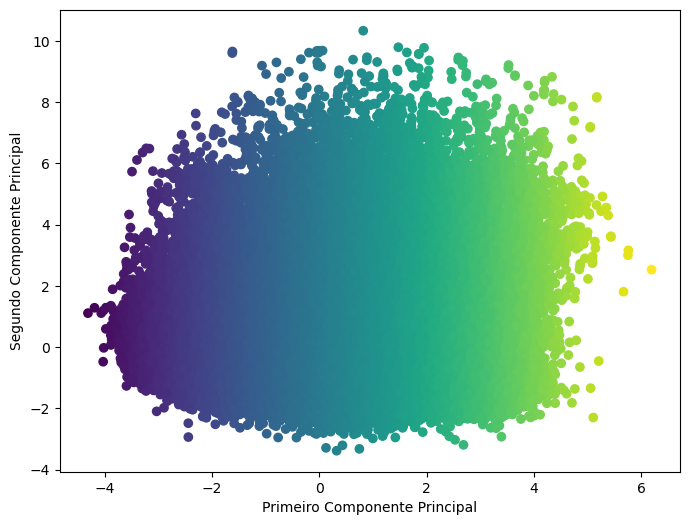

In [15]:
plt.figure(figsize=(8, 6))
plt.scatter(data_numeric['PCA1'], data_numeric['PCA2'], c=data_numeric['PCA1'], cmap='viridis')
plt.xlabel('Primeiro Componente Principal')
plt.ylabel('Segundo Componente Principal')
plt.show()

### Utilizamos o K-means para agrupamento (Clustering)
### Escolhemos o número de clusters usando o método do cotovelo (Elbow Method)

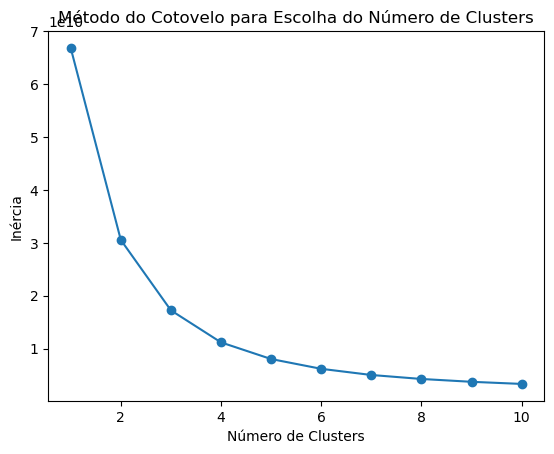

In [16]:
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_numeric)
    inertia.append(kmeans.inertia_)

# Plotando o gráfico do método do cotovelo
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Inércia')
plt.title('Método do Cotovelo para Escolha do Número de Clusters')
plt.show()

### Aplicação do algoritmo K-means com o número escolhido de clusters

In [17]:
kmeans = KMeans(n_clusters=4, random_state=42)
data_numeric['cluster'] = kmeans.fit_predict(data_numeric)

### Plotamos novamente o gráfico, mas agora com o clusters definidos pelo K-means

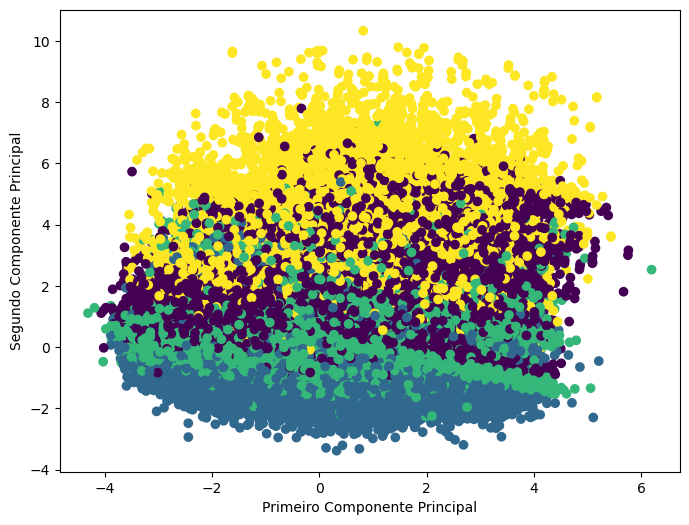

In [18]:
plt.figure(figsize=(8, 6))
plt.scatter(data_numeric['PCA1'], data_numeric['PCA2'], c=data_numeric['cluster'], cmap='viridis')
plt.xlabel('Primeiro Componente Principal')
plt.ylabel('Segundo Componente Principal')
plt.show()

In [32]:
dbscan = DBSCAN(eps=0.02, min_samples=5)  
cluster_labels = dbscan.fit_predict(data_numeric[corr_cols])
data_numeric['Cluster_DBSCAN'] = cluster_labels
cluster_labels

array([-1, -1, -1, ..., -1, -1, -1], dtype=int64)

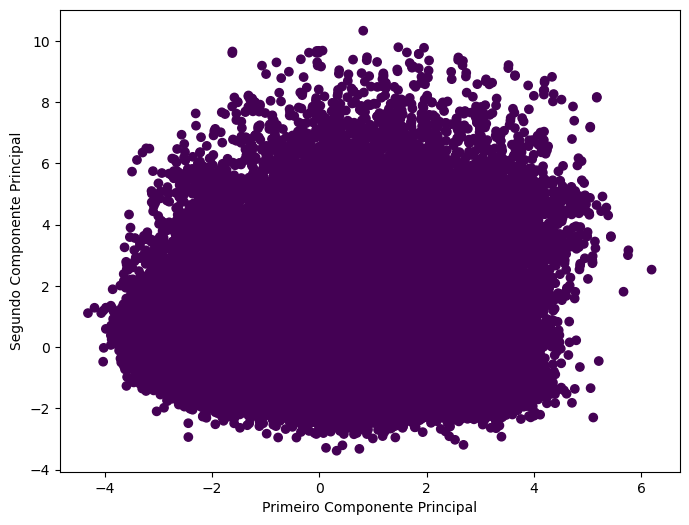

In [33]:
plt.figure(figsize=(8, 6))
plt.scatter(data_numeric['PCA1'], data_numeric['PCA2'], c=data_numeric['Cluster_DBSCAN'], cmap='viridis')
plt.xlabel('Primeiro Componente Principal')
plt.ylabel('Segundo Componente Principal')
plt.show()

## Conclusões

- O algoritmo que conseguiu realizar algum agrupamento entre as instâncias foi o kmeans.
- O DBSCAN não encontrou grupos diferentes, mesmo variando alguns parametros do algoritmo.
- Foi possível encontrar algumas variáveis correlacionadas ao utilizar a matriz de correlações como por exemplo peso da criança e duraçao da gravidez

### 